In [270]:
%pylab inline
import scipy
from pyiga import bspline, assemble, geometry, vis

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [271]:

# define isogeometric Taylor-Hood discretization space
p = 3    # spline degree of velocity space
n_el = (50, 10)   # number of elements in x,y direction

# deformation space: degree p,   continuity p-1
# stability term space: degree p-1, continuity p-2
kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=1) for n in n_el)
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

m_u = tuple(kv.numdofs for kv in kvs_u)


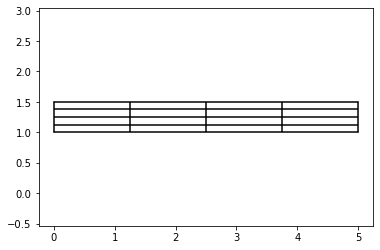

In [272]:
# define geometry
# undeformed stick
geo = geometry.tensor_product(geometry.line_segment(1,1.5), geometry.line_segment(0,5, intervals=5))
vis.plot_geo(geo, grid=5)
axis('equal');

In [273]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)
#Mu = 0.003 * 1e+9 #300000 #0.003*10^9 #(shear modulus, rubber: 0.003 GPa)
#Lam= 0.00028416 * 1e+9 #284160 #0.00028416*10^9 # [Pa]

# assemble the System matrix
def linelast_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(2,2)) # vector valued
    e_u = 1/2 * (grad(u) + grad(u).T)
    e_v =  1/2 * (grad(v) + grad(v).T)
    vf.add(2* Mu *inner(e_u,e_v) * dx)
    return vf

A_grad = assemble.assemble_vf(linelast_vf(2), kvs_u, geo=geo, symmetric=True)

A_div  = - assemble.assemble('div(u) * p * dx', (kvs_u, kvs_p), bfuns=[('u',2,0), ('p',1,1)], geo=geo)

A_c  = assemble.assemble('p * q * dx', kvs_p, bfuns=[('p',1,0), ('q',1,0)], geo=geo)/Lam

A_lin_el = scipy.sparse.bmat(
    [[A_grad, A_div.T],
     [A_div,  -A_c]], format='csr')

print(shape(A_grad))
print(shape(A_div))
print(shape(A_c))

(1378, 1378)
(624, 1378)
(624, 624)


In [274]:
# define Dirichlet boundary conditions
# def g_def(x, y):  return (0.0, (1-y)*(1.5-y)) # at boundary = 0 , only in 2nd component
def g_zero(x, y): return (0.0, 0.0)

# set inhom. Neumann cond. on distal end, hom. NBC elsewhere
bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
        [('left', g_zero)])  # left: dirichlet boundary cond.



In [286]:
# surface integral: g*v ds
# TODO: assemble rhs (boundary functional g*v ds)

#def g(x, y): return (0,-3e-7) # Neumann BC function
def g0(x,y):
    if (x>4).all():
        return -3e-7 # set force at distal end only
    else:
        return 0
    
def g(x,y):
    #print(x)
    if isinstance(x,numpy.float64):
        #print( (0,g0(x,y)) )
        return (0,g0(x,y))
    #print((0,-3e-7*x))
    #print ((0,[g0(xi,0) for xi in np.nditer(x)]))
    return (0,[g0(xi,0) for xi in np.nditer(x)])

# assemble neumann condition
gn= assemble.assemble('inner(g,v)*ds', kvs_u, bfuns=[('v',2)], geo=geo, g=g, boundary='top')
g2= assemble.boundary_dofs(kvs_u,'top',ravel=True) # gives us all boundary dofs
#print(gn)
# incorporate neumnann boundary condition
shape_a= shape(A_grad)[0]
nbc= np.zeros(shape(A_lin_el)[0])
for i in range(len(g2)):
    nbc[g2[i]]= gn[0,0,i] #gn[0,i,0],gn[0,0,i]
    nbc[g2[i]+shape_a//2]= gn[1,0,i] #gn[1,i,0], gn[1,0,i]
    
#print(shape(A_lin_el))
#print(shape_a)
#print(nbc)

In [276]:
f = lambda x,y: (0,0) # source term

rhs = assemble.inner_products(kvs_u, f, f_physical=True, geo=geo).ravel()
rhs= np.pad(rhs, (0,shape(A_c)[0]))
#print(shape(rhs))

In [277]:
# solve Linear elasticity problem with the given boundary conditions and 0 right-hand side
LS = assemble.RestrictedLinearSystem(A_lin_el, rhs+nbc, bcs)
u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u = LS.complete(u)
print(u)

[ 0.00000000e+00 -8.77259808e-04 -2.49344464e-03 ... -6.21777841e-08
  1.87861421e-08  9.98758940e-09]


In [278]:
# split the solution into its components (displacement in x- and y- direction)
N = np.prod(tuple(kv.numdofs for kv in kvs_u))
u1 = u[:N].reshape(m_u)
u2 = u[N:2*N].reshape(m_u)
U = np.stack((u1,u2), axis=-1)

# construct B-spline function with input arguments: coeff, basis functions (kvs), u_hat(x)
displ = geometry.BSplineFunc(kvs_u, U) 

In [279]:
# evaluate displacement over a grid in the parameter domain
xgrid = linspace(0, 1, 20)
xygrid = (xgrid, xgrid) # grid: 20*20 (x*y)

G = geo.grid_eval(xygrid)
dis = displ.grid_eval(xygrid)
#print(shape(dis))
#print(dis)

In [280]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

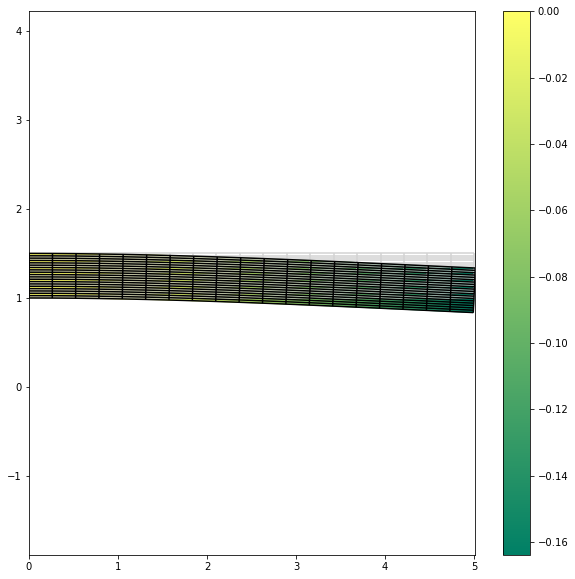

In [281]:
# plot deformation
#plt.subplot(226)
figsize(10,10)
fig, ax = plt.subplots()

plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")
plot_grid(G[...,0]+dis[...,0], G[...,1]+dis[...,1], ax=ax, color="black")

# colormesh w.r.t. displacement & deformed quater annulus
pcolormesh(G[...,0]+dis[...,0], G[...,1]+dis[...,1], dis[...,1], cmap='summer', shading='gouraud');
colorbar();

axis('equal');

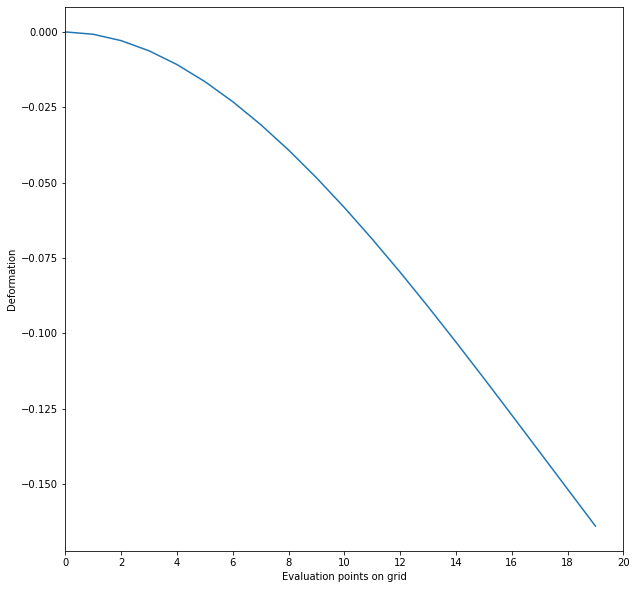

In [282]:
y_val=[]
for i in range(len(dis)):
    y_val = np.append(y_val,dis[0,i,1])

fig, ax = plt.subplots()
ax.set_ylabel('Deformation')
ax.set_xlabel('Evaluation points on grid')
  
ax.set_xlim(0, 20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(y_val)

plt.show()

#print(dis[0,...,1])